# Classifying Poetry

* Discriminate between Robert Frost and Edgar Allan Poe poems
* Given only sequence of parts-of-speech tags
* 60-70% accuracy on validation set with HMM
* We will see if RNN could improve the performance compared with HMM

### Data Processing

* POS tag is the role of a word in a sentence: noun, pronoun, adverb, determiner, adjective, etc, ...
* Given a sentence (aka, a sequence of words), we get a sequence of POS tags for each word. 
* We will be using NLTK (Natural Language Tool Kit) to parse sentences. 
    * sudo pip install nltk
    * nltk.download to get necessary packages
    
* Convert sequence of POS tags into sequence of indices of POS tags (same as we did with words).
* Dimentionality will be much smaller than word vacabulary since there are not that many POS tags.
* Do not need tag-index mapping since we do not care what the actual tags are. We just need to be able to differentiate them in order to do classification.

## The Classifier

* No word embeddings: one-hot vector for POS tags goes straight into recurrent unit
* $ W_x $ will be $ V \times M $ instead of $ D \times M $ (no $D$ anymore)
* The number of classes K = 2 instead of V
    * This classifier assigns one label for each sequence
    * We only care about output at end of sequence (after the RNN considers the entire sequence)
* We are going to use a variable learning rate because the cost function jumping around at later epochs
    * learning_rate *= 0.9999 at each epoch

In [29]:
import theano
import theano.tensor as T
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk
import os
from nltk import pos_tag, word_tokenize
from sklearn.utils import shuffle


In [30]:
def get_tags(s):
    # The tuples contain word and the POS tag, we only return POS tag.
    tuples = pos_tag(word_tokenize(s))
    return [y for x, y in tuples]

In [32]:
get_tags("Welcome to this project")

['VB', 'TO', 'DT', 'NN']

In [42]:
def get_poetry_classifier_data(samples_per_class, load_cached=True, save_cached=True):
    datafile = 'poetry_classifier_data_npz'
    if load_cached and os.path.exists(datafile):
        npz = np.load(datafile)
        X = npz['arr_0']
        Y = npz['arr_1']
        V = int(npz['arr_2'])
        return X, Y, V
    
    word2idx = {}
    current_idx = 0
    X = []
    Y = []
    for fn, label in zip(('../data/hmm/edgar_allan_poe.txt','../data/hmm/robert_frost.txt'), (0, 1)):
        count = 0
        for line in open(fn):
            line = line.rstrip()
            if line:
#                 print(line)
                tokens = get_tags(line)
                for token in tokens:
                    if token not in word2idx:
                        word2idx[token] = current_idx
                        current_idx += 1
                        
                sequence = np.array([word2idx[w] for w in tokens])
                X.append(sequence)
                Y.append(label)
                count += 1
                
                if count >= samples_per_class:
                    break
        
    if save_cached:
        np.savez(datafile, X, Y, current_idx)
        
    return X, Y, current_idx


In [14]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

In [72]:
class SimpleRNN(object):
    def __init__(self, M, V):
        self.M = M
        self.V = V
        
    def fit(self, X, Y, learning_rate=10e-1, mu=0.99, reg=1.0, activation=T.tanh, epochs=500, show_fig=False):

        self.K = len(set(Y))
        print("V:", V)
        
        X, Y = shuffle(X, Y)
        Nvalid = 10
        Xvalid, Yvalid = X[-Nvalid:], Y[-Nvalid:]
        X, Y = X[:-Nvalid], Y[:-Nvalid]
        N = len(X)
        
        Wx = init_weight(self.V, self.M)
        Wh = init_weight(self.M, self.M)
        Wo = init_weight(self.M, self.K)
        bh = np.zeros(self.M)
        h0 = np.zeros(self.M)
        bo = np.zeros(self.K)
        
        ### forward/prediction part 
        
        thX, thY, py_x, prediction = self.set_forward(Wx, Wh, Wo, bh, h0, bo, activation)
        
        ### gradient descent and optimizer
        
        #
        cost = -T.mean(T.log(py_x[thY]))
        grads = T.grad(cost, self.params)
        
        # pitfall:
        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        
        # we define learning rate as a theano variable since we will update learning rate after each epoch
        lr = T.scalar('learning_rate')
        
        updates = [
            (p, p + mu*dp - lr*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - lr*g) for dp, g in zip(dparams, grads)
        ]
        
        self.train_op = theano.function(
            inputs=[thX, thY, lr],
            outputs=[cost, prediction],
            updates= updates,
            allow_input_downcast=True,
        )
        
        ### training
        
        costs=[]
        
        for i in range(epochs):
            
            # pitfall:
            X, Y = shuffle(X, Y)
            n_correct = 0
            cost = 0
            for j in range(N):
                
                # Using stochastic gradient descent
                c, p = self.train_op(X[j], Y[j], learning_rate)
                cost += c
                if p == Y[j]:
                    n_correct += 1
            learning_rate *= 0.9999
            
            n_correct_valid = 0
            for j in range(Nvalid):
                p = self.prediction_op(Xvalid[j])
                if p == Yvalid[j]:
                    n_correct_valid += 1
                
            if i % 20 == 0:
                print("i:", i, "cost:", cost, "correct rate:", (float(n_correct)/ N))
                print("validation correct rate:", (float(n_correct_valid/Nvalid)))
            costs.append(cost)
        
        if show_fig:
            plt.plot(costs)
            plt.show()
            
        
    def set_forward(self, Wx, Wh, Wo, bh, h0, bo, activation):
        
        self.f = activation
        
        self.Wx = theano.shared(Wx)
        self.Wh = theano.shared(Wh)
        self.Wo = theano.shared(Wo)
        self.bh = theano.shared(bh)
        self.h0 = theano.shared(h0)
        self.bo = theano.shared(bo)
        self.params = (self.Wx, self.Wh, self.Wo, self.bh, self.h0, self.bo)
        
        thX = T.ivector('X')
        
        # since we only have one target per sequence, the thY is scalar
        thY = T.iscalar('Y')
        
        ## recurrent part
        
        def recurrence(x_t, h_t1):
            # NOTE: we index Wx with POS tag vector
            h_t = self.f(self.Wx[x_t] + h_t1.dot(self.Wh) + self.bh)
            y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo) 
            return h_t, y_t
        
        
        [h, y], _ = theano.scan(
            fn=recurrence,
            sequences=thX,
            outputs_info=[self.h0, None],
            n_steps=thX.shape[0],
        )
        
        # only interested in the final classification of the sequence
        py_x = y[-1, 0, :]
        prediction = T.argmax(py_x)
        
        self.prediction_op = theano.function(
                inputs=[thX],
                outputs=prediction,
                allow_input_downcast=True,
        )  
        
        return thX, thY, py_x, prediction
        
    def save(self, filename):
        np.savez(filename, *[p.get_value() for p in self.params])
        
    @staticmethod
    def load(filename, activation):
        npz = np.load(filename)
        Wx = npz['arr_0']
        Wh = npz['arr_1']
        Wo = npz['arr_2']
        bh = npz['arr_3']
        h0 = npz['arr_4']
        
        V, M = Wx.shape
        rnn = SimpleRNN(M, V)
        rnn.set_weights(Wx, Wh, Wo, bh, h0, bo, activation)
        return rnn
        
        

In [64]:
X, Y, V = get_poetry_classifier_data(samples_per_class=500)
X

[array([0, 1, 2, 0, 0, 3, 4, 5, 0]),
 array([6, 5, 7, 0, 8, 5, 9, 8]),
 array([2, 9, 6, 5, 0, 0]),
 array([10,  5,  7,  8, 11,  5,  7,  8, 11,  5, 12,  8, 11,  5, 12,  8]),
 array([13, 14, 15, 16,  7,  0,  1]),
 array([17, 18,  8, 11, 18,  8, 11, 18]),
 array([ 2,  9,  6,  5,  0,  6, 18]),
 array([19,  5,  1, 20,  5,  1,  9,  9,  0]),
 array([15, 21,  6,  5,  7,  0,  1]),
 array([ 7, 18, 22,  7,  9,  1]),
 array([ 7,  0, 22, 20,  9,  1]),
 array([ 6,  8,  6, 23, 18, 24,  8]),
 array([9, 6, 5, 0]),
 array([ 5,  7, 18, 13,  1]),
 array([ 5,  7, 18,  6,  7, 13, 25]),
 array([6, 5, 7, 0, 6, 5, 0, 8]),
 array([11,  0,  6,  6,  5,  7,  0]),
 array([ 2, 25,  5, 18,  9]),
 array([ 9, 20,  6,  7, 18]),
 array([ 6,  7, 26,  0, 11,  0, 18]),
 array([ 9, 20, 25, 18,  6,  9, 18]),
 array([ 9, 20,  6,  2, 18]),
 array([9, 7, 5, 7, 0]),
 array([ 7, 18, 13]),
 array([ 5,  0,  5,  0, 11,  5,  0,  1]),
 array([17,  7, 18, 13, 18]),
 array([ 2,  6,  5,  0,  6,  5, 18]),
 array([11,  9,  5, 18,  9,  6,  0

V: 41
i: 0 cost: 687.56625308 correct rate: 0.4919191919191919
validation correct rate: 0.6
i: 20 cost: 681.894221882 correct rate: 0.5565656565656566
validation correct rate: 0.4
i: 40 cost: 678.338300929 correct rate: 0.5646464646464646
validation correct rate: 0.5
i: 60 cost: 675.617358573 correct rate: 0.5767676767676768
validation correct rate: 0.7
i: 80 cost: 673.15820403 correct rate: 0.5858585858585859
validation correct rate: 0.7
i: 100 cost: 670.724151818 correct rate: 0.5868686868686869
validation correct rate: 0.7
i: 120 cost: 668.187510011 correct rate: 0.5909090909090909
validation correct rate: 0.7
i: 140 cost: 665.492918099 correct rate: 0.591919191919192
validation correct rate: 0.7
i: 160 cost: 662.427754627 correct rate: 0.5949494949494949
validation correct rate: 0.7
i: 180 cost: 658.522178982 correct rate: 0.597979797979798
validation correct rate: 0.7
i: 200 cost: 652.968655847 correct rate: 0.6101010101010101
validation correct rate: 0.7
i: 220 cost: 642.67331259

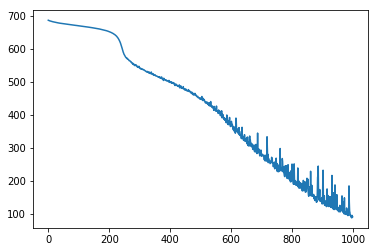

In [73]:
rnn = SimpleRNN(30, V)
rnn.fit(X, Y, learning_rate=10e-7, show_fig=True, activation=T.nnet.relu, epochs=1000)